In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
import os
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

In [2]:
# dataset paths
data_train_path = './train_folder'
data_test_path = './test_folder'

# Classes
classes = os.listdir(data_train_path)
num_classes = len(classes)

print("Total number of classes: " + str(num_classes))

Total number of classes: 9


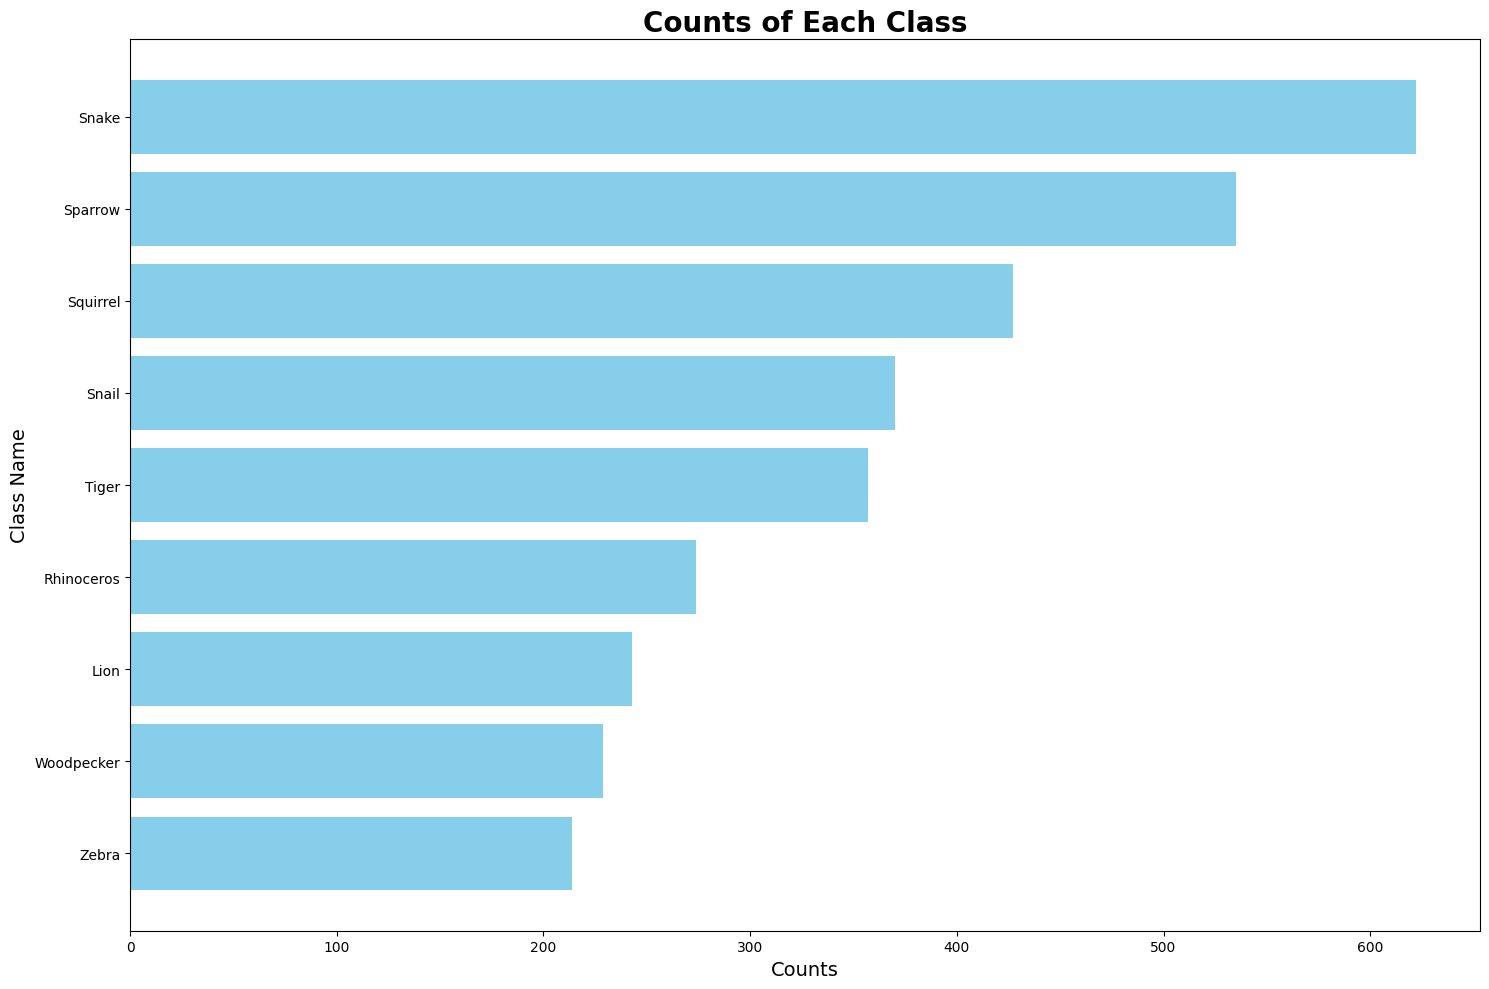

In [3]:
counts = []

for n_class in classes:
    class_path = os.path.join(data_train_path, n_class)
    count = len(os.listdir(class_path))
    counts.append((n_class, count))

counts = pd.DataFrame(counts, columns=['Class Name', 'Counts'])

counts = counts.sort_values(by='Counts', ascending=False)

plt.figure(figsize=(15, 10))
plt.barh(counts['Class Name'], counts['Counts'], color='skyblue')
plt.xlabel('Counts', fontsize=14)
plt.ylabel('Class Name', fontsize=14)
plt.title('Counts of Each Class', fontsize=20, fontweight='bold')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

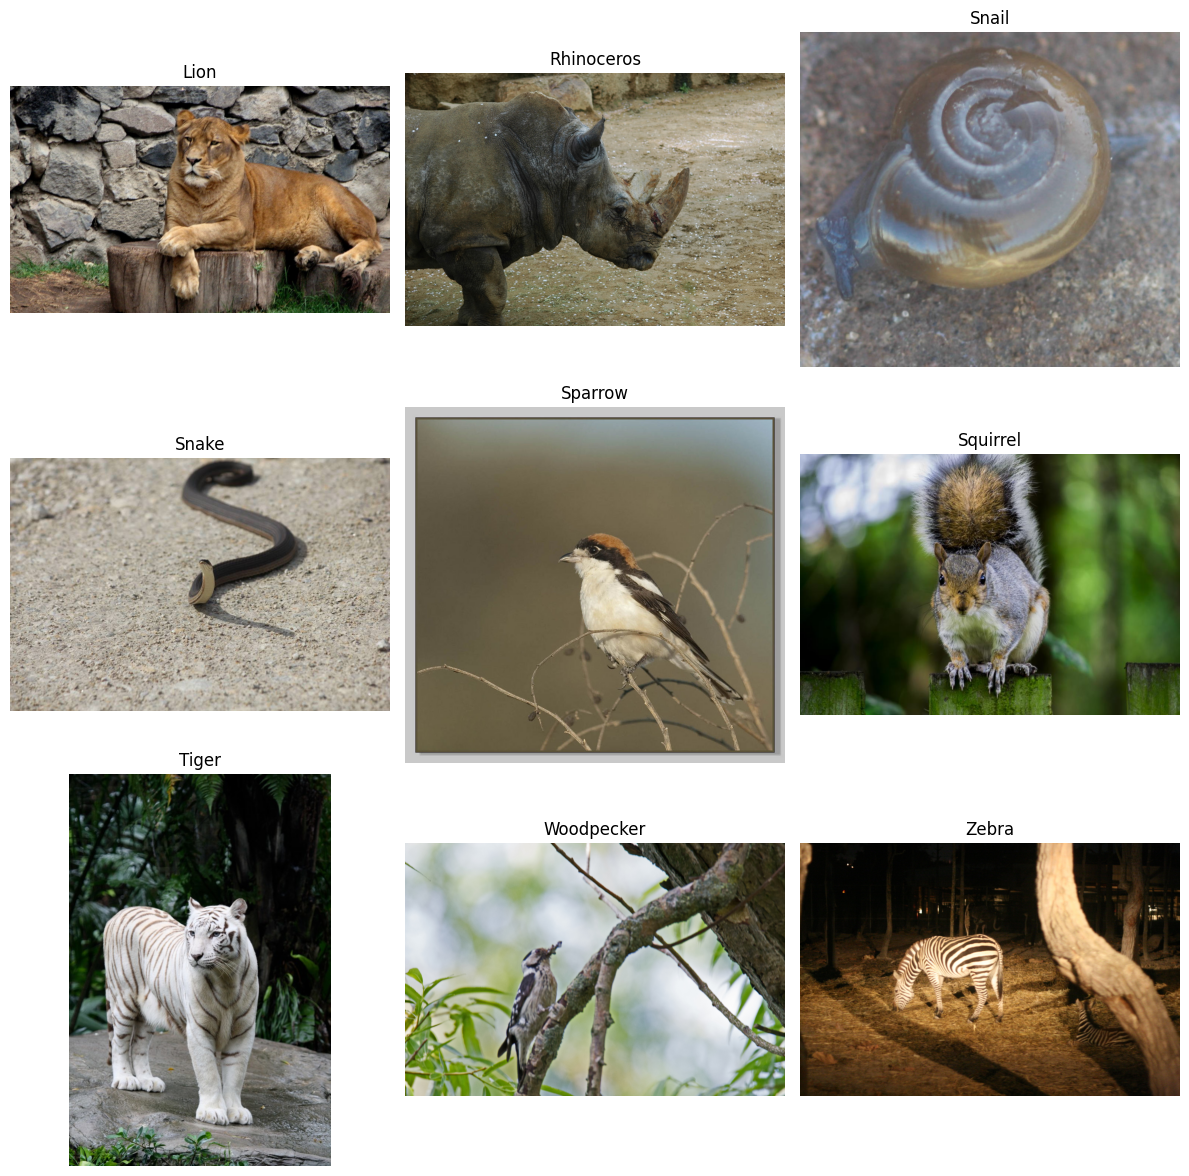

In [4]:
fig, ax = plt.subplots(3, 3, figsize=(12, 12))

for i in range(len(classes)):
    class_name = classes[i]
    class_path = os.path.join(data_train_path, class_name)
    
    img_files = [f for f in os.listdir(class_path) if f.endswith('.jpg')]
    img_path = os.path.join(class_path, img_files[0])
    
    img = cv.imread(img_path)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

    row = i // 3
    col = i % 3

    ax[row, col].imshow(img)
    ax[row, col].axis('off')
    ax[row, col].set_title(class_name)

plt.tight_layout()
plt.show()

In [5]:
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
SIZE = IMAGE_SIZE[0]

# Load the full training dataset (will be split later)
full_train_ds = tf.keras.utils.image_dataset_from_directory(
    directory=data_train_path,
    labels='inferred',
    label_mode='categorical',
    class_names=classes,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
)

# Preprocessing and performance optimization
full_train_ds = full_train_ds.shuffle(1024).prefetch(tf.data.AUTOTUNE)

# Count total number of batches
total_batches = tf.data.experimental.cardinality(full_train_ds).numpy()
train_batches = int(0.9 * total_batches)
val_batches = total_batches - train_batches

# Dividir o dataset em treino (90%) e validação (10%)
train_ds = full_train_ds.take(train_batches)
valid_ds = full_train_ds.skip(train_batches)

# Data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

# Normalization layer
normalization_layer = tf.keras.layers.Rescaling(1./255)

# Apply augmentation and normalization to training set
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)).prefetch(tf.data.AUTOTUNE)

# Apply only normalization to validation set
valid_ds = valid_ds.map(lambda x, y: (normalization_layer(x), y)).prefetch(tf.data.AUTOTUNE)

# Split the dataset: 90% for training and 10% for validation
test_ds = tf.keras.utils.image_dataset_from_directory(
    directory=data_test_path,
    labels='inferred',
    label_mode='categorical',
    class_names=classes,
    shuffle=False,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
)

test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y)).prefetch(tf.data.AUTOTUNE)

# Print dataset sizes
print("Total batches:", total_batches + tf.data.experimental.cardinality(test_ds).numpy())
print("Train batches:", train_batches)
print("Validation batches:", val_batches)
print("Test batches:", tf.data.experimental.cardinality(test_ds).numpy())

Found 3271 files belonging to 9 classes.
Found 744 files belonging to 9 classes.
Total batches: 127
Train batches: 92
Validation batches: 11
Test batches: 24


In [6]:
model = Sequential([
    layers.Conv2D(6, kernel_size=5, strides=1, activation='tanh', input_shape=(SIZE, SIZE, 3), padding='valid'),  # output: 28x28x6
    layers.AveragePooling2D(pool_size=2, strides=2),  # output: 14x14x6
    layers.Conv2D(16, kernel_size=5, strides=1, activation='tanh', padding='valid'),  # output: 10x10x16
    layers.AveragePooling2D(pool_size=2, strides=2),  # output: 5x5x16
    layers.Conv2D(120, kernel_size=5, strides=1, activation='tanh'),  # output: 1x1x120
    layers.Flatten(),
    layers.Dense(84, activation='tanh'),
    layers.Dense(num_classes, activation='softmax')
])

In [7]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Show the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 6)       456       
                                                                 
 average_pooling2d (Average  (None, 110, 110, 6)       0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 106, 106, 16)      2416      
                                                                 
 average_pooling2d_1 (Avera  (None, 53, 53, 16)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_2 (Conv2D)           (None, 49, 49, 120)       48120     
                                                                 
 flatten (Flatten)           (None, 288120)           

In [8]:
# Train model by .fit function
history = model.fit(
    train_ds,                                          # Dataset to train model
    epochs=100,                                        # Number of epochs to train
    validation_data=valid_ds                          # Validation dataset
)

Epoch 1/100
92/92 [==============================] - 73s 746ms/step - loss: 2.4058 - accuracy: 0.1812 - val_loss: 2.1484 - val_accuracy: 0.1960
Epoch 2/100
92/92 [==============================] - 66s 679ms/step - loss: 2.0843 - accuracy: 0.2141 - val_loss: 2.0622 - val_accuracy: 0.1989
Epoch 3/100
92/92 [==============================] - 68s 706ms/step - loss: 2.0188 - accuracy: 0.2456 - val_loss: 1.9296 - val_accuracy: 0.3153
Epoch 4/100
92/92 [==============================] - 62s 638ms/step - loss: 1.9818 - accuracy: 0.2754 - val_loss: 1.9401 - val_accuracy: 0.2784
Epoch 5/100
92/92 [==============================] - 61s 632ms/step - loss: 1.9479 - accuracy: 0.2816 - val_loss: 1.9042 - val_accuracy: 0.3125
Epoch 6/100
92/92 [==============================] - 62s 636ms/step - loss: 1.9370 - accuracy: 0.2861 - val_loss: 1.8707 - val_accuracy: 0.3125
Epoch 7/100
92/92 [==============================] - 64s 659ms/step - loss: 1.9109 - accuracy: 0.3073 - val_loss: 1.8588 - val_accuracy:

In [9]:
# Convert resutl of training to a DataFrame
result_df = pd.DataFrame(history.history)
# Show 5 tails of dataframe
result_df.tail()

loss  accuracy  val_loss  val_accuracy
95  1.395793  0.522097  1.308659      0.568182
96  1.378179  0.523124  1.241799      0.602273
97  1.376126  0.518342  1.213995      0.596591
98  1.376898  0.523810  1.224244      0.590909
99  1.390764  0.513532  1.259951      0.571023

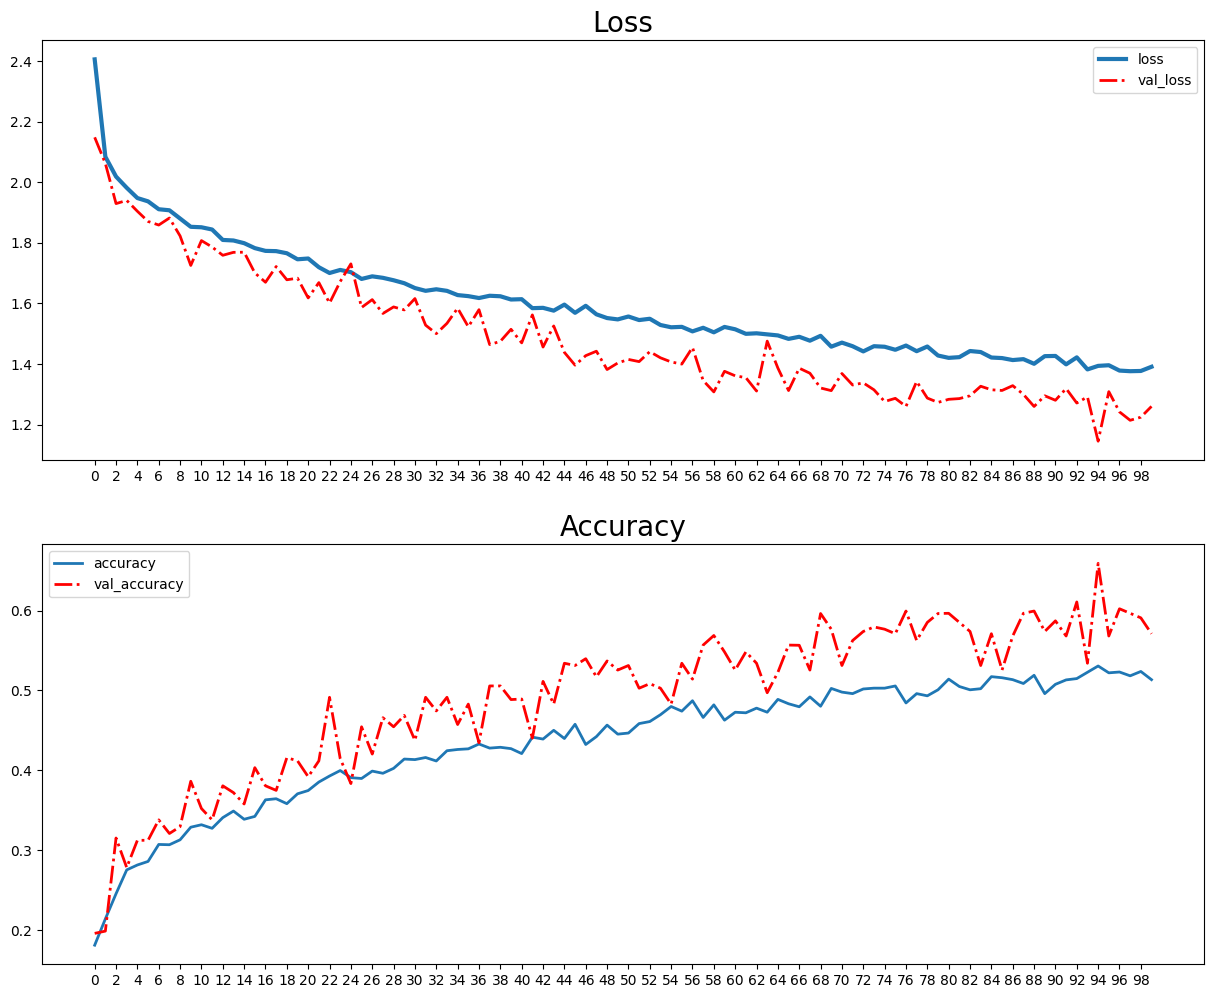

In [10]:
# Define a X variable to store range of epochs
x = np.arange(len(result_df))

# Create a plot with 3 row and 1 col with size of (15, 12)
fig, ax = plt.subplots(2, 1, figsize=(15, 12))

# AX0 : Loss
ax[0].plot(x, result_df.loss, label='loss', linewidth=3)                          
ax[0].plot(x, result_df.val_loss, label='val_loss', linewidth=2, ls='-.', c='r')
ax[0].set_title('Loss', fontsize=20)
ax[0].set_xticks(np.arange(0, len(x), 2))
ax[0].legend()

#  AX1 : Loss
ax[1].plot(x, result_df.accuracy, label='accuracy', linewidth=2)
ax[1].plot(x, result_df.val_accuracy, label='val_accuracy', linewidth=2, ls='-.', c='r')
ax[1].set_title('Accuracy', fontsize=20)
ax[1].set_xticks(np.arange(0, len(x), 2))
ax[1].legend()

# #  AX2 : Loss
# ax[2].plot(x, result_df.learning_rate, label='learning_rate', linewidth=2, marker='o')
# ax[2].set_title('learning_rate', fontsize=20)
# ax[2].set_xlabel('epochs')
# ax[2].set_xticks(np.arange(0, len(x), 2))
# ax[2].legend()

plt.show()

In [11]:
# checkpoint callback, save base model weights in "MyModel.keras".
# So, we should load it by keras.models.load_model
# best_model = tf.keras.models.load_model('MyModel.keras')

In [12]:
# # Evaluate model by model.evaluate()
# loss, accuracy = model.evaluate(test_ds)
# print()
# print(f'Loss : {loss}')
# print(f'Accuracy : {accuracy*100}%')

# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_ds)
print(f'Test Loss       : {loss:.4f}')
print(f'Test Accuracy   : {accuracy * 100:.2f}%')

# Get predictions and true labels
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

# Compute additional metrics
precision_macro = precision_score(y_true, y_pred, average='macro')
recall_macro = recall_score(y_true, y_pred, average='macro')
f1_macro = f1_score(y_true, y_pred, average='macro')

precision_micro = precision_score(y_true, y_pred, average='micro')
recall_micro = recall_score(y_true, y_pred, average='micro')
f1_micro = f1_score(y_true, y_pred, average='micro')

f1_weighted = f1_score(y_true, y_pred, average='weighted')

# Print all metrics
print()
print("Additional Evaluation Metrics:")
print(f"Macro Precision : {precision_macro:.4f}")
print(f"Macro Recall    : {recall_macro:.4f}")
print(f"Macro F1 Score  : {f1_macro:.4f}")
print(f"Micro F1 Score  : {f1_micro:.4f}")
print(f"Weighted F1     : {f1_weighted:.4f}")


24/24 [==============================] - 3s 135ms/step - loss: 1.9420 - accuracy: 0.3212
Test Loss       : 1.9420
Test Accuracy   : 32.12%
1/1 [==============================] - 0s 94ms/step

Additional Evaluation Metrics:
Macro Precision : 0.2773
Macro Recall    : 0.2915
Macro F1 Score  : 0.2700
Micro F1 Score  : 0.3212
Weighted F1     : 0.3339


1/1 [==============================] - 0s 47ms/step


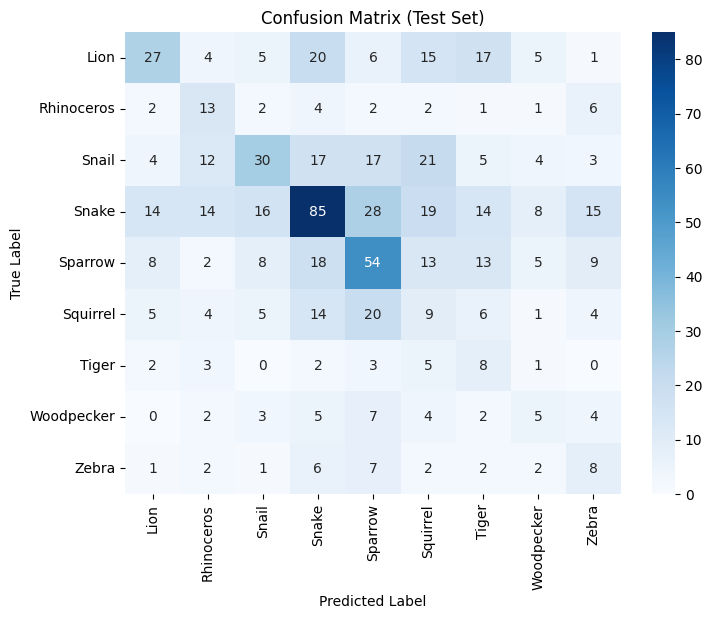

In [13]:
# Confusion Matrix

# Get predictions and true labels from the test set
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)
class_names = classes  # use the already defined list of class names

# Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Test Set)')
plt.show()

1/1 [==============================] - 0s 31ms/step


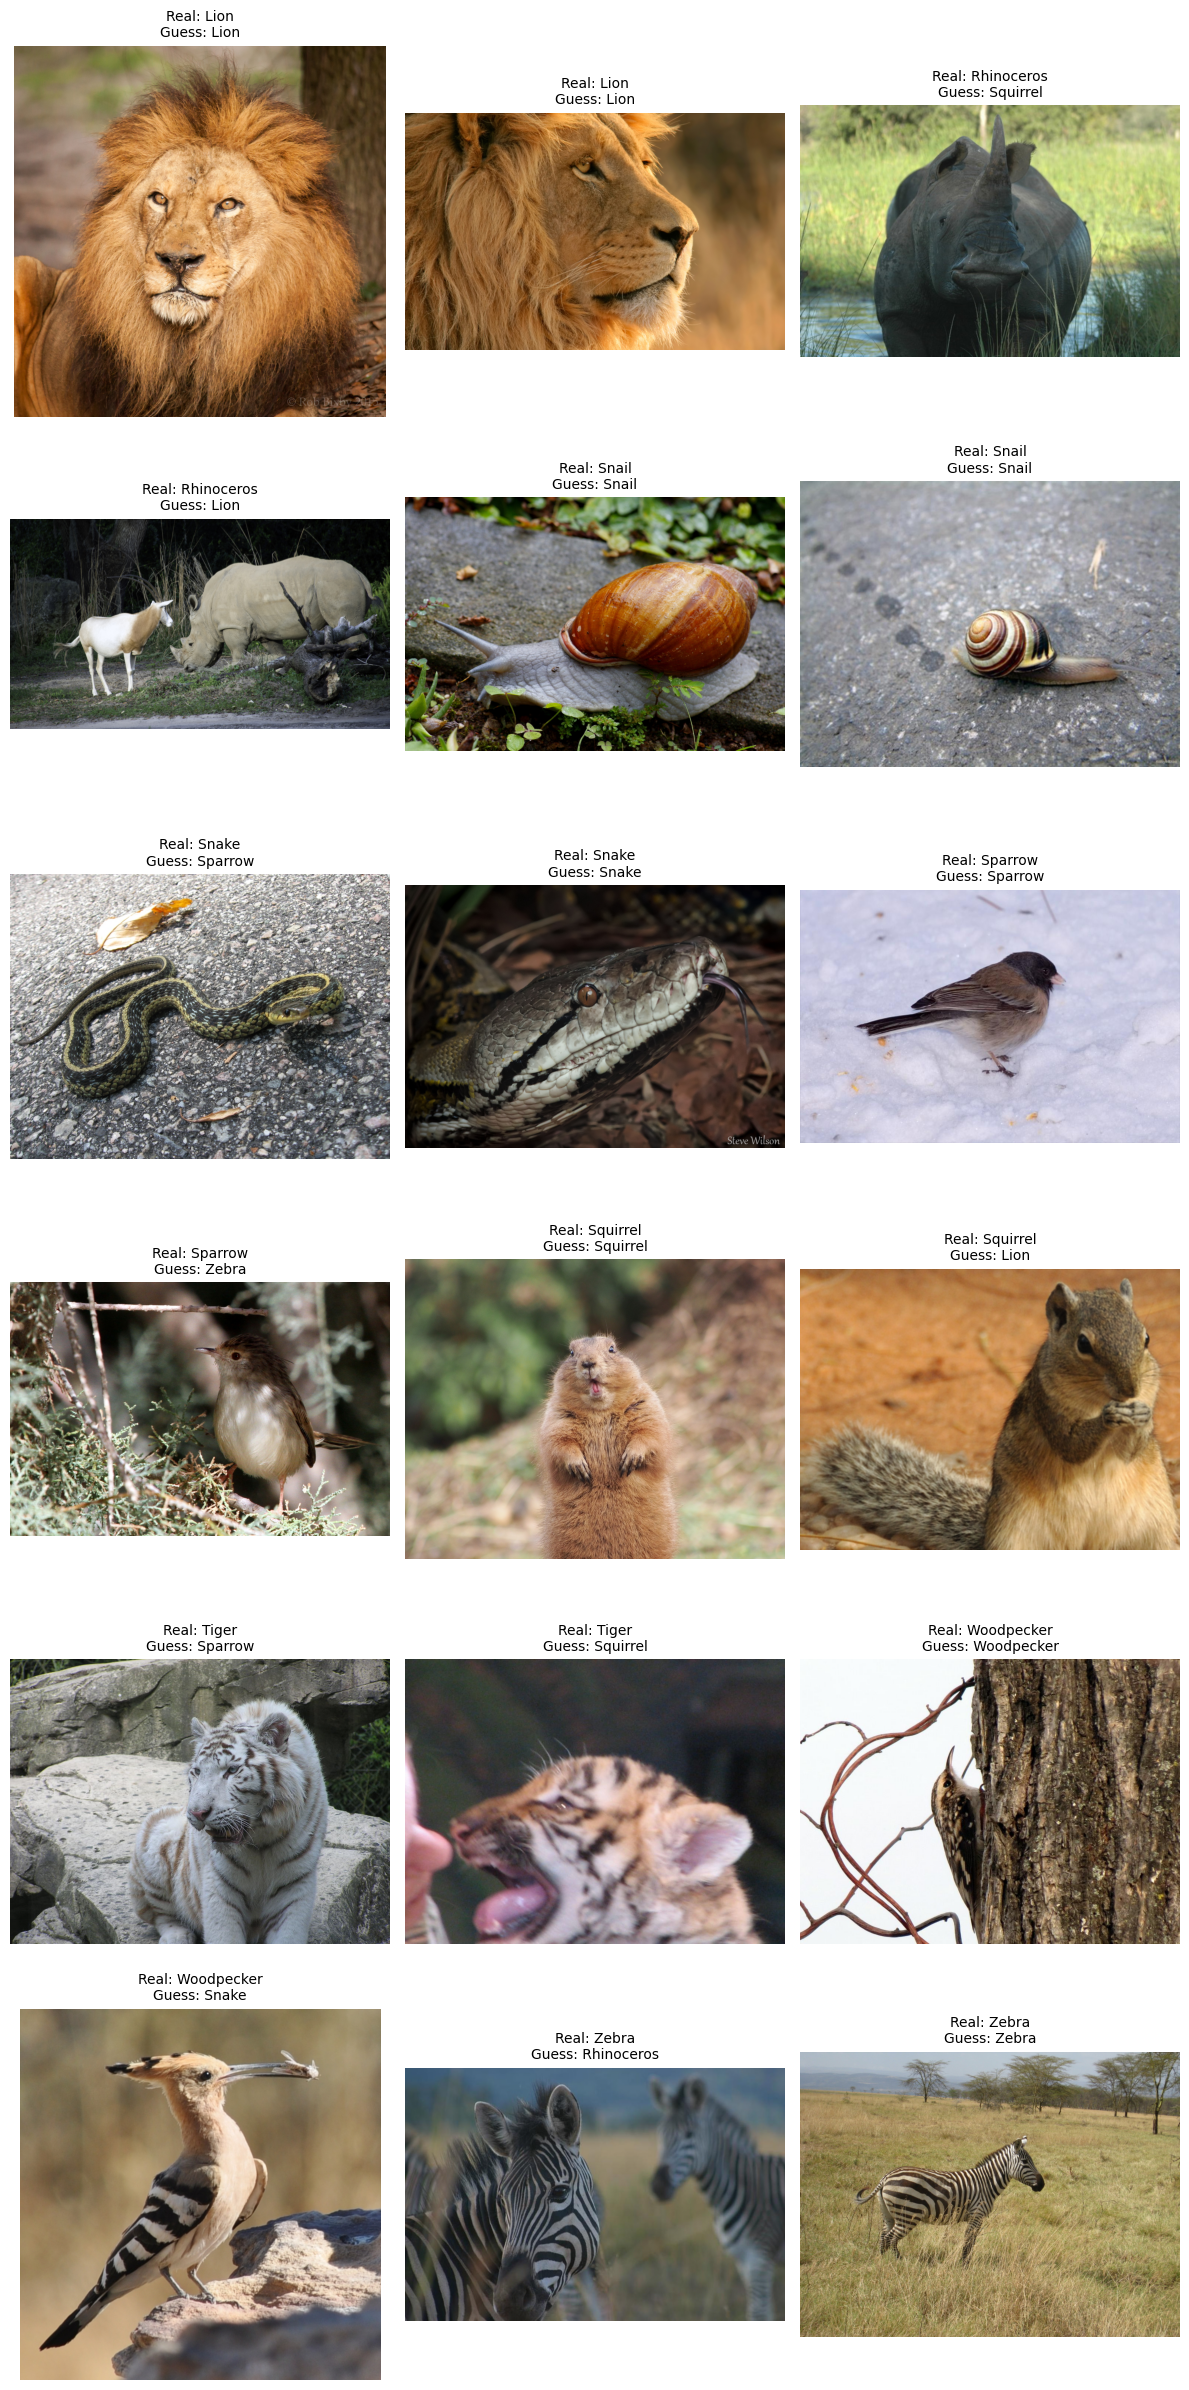

In [14]:
images_per_class = 2
total_images = len(classes) * images_per_class
rows = (total_images + 2) // 3

fig, ax = plt.subplots(rows, 3, figsize=(12, 4 * rows))

for i, class_name in enumerate(classes):
    class_path = os.path.join(data_test_path, class_name)
    img_files = [f for f in os.listdir(class_path) if f.endswith('.jpg')]

    for j in range(images_per_class):
        idx = i * images_per_class + j
        if idx >= total_images or j >= len(img_files):
            continue  

        img_path = os.path.join(class_path, img_files[j])
        img = cv.imread(img_path)
        img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)

        # Resize and normalize the image for the model
        img_resized = cv.resize(img_rgb, IMAGE_SIZE)
        input_img = normalization_layer(tf.convert_to_tensor(img_resized[np.newaxis, ...], dtype=tf.float32))[0].numpy()
        input_tensor = np.expand_dims(input_img, axis=0)

        prediction = model.predict(input_tensor)
        pred_class = tf.argmax(prediction, axis=1).numpy()[0]

        row = idx // 3
        col = idx % 3

        ax[row, col].imshow(img_rgb)
        ax[row, col].axis('off')
        ax[row, col].set_title(f"Real: {class_name}\nGuess: {classes[pred_class]}", fontsize=10)

plt.tight_layout()
plt.show()
